<a href="https://colab.research.google.com/github/abdulhaseeb-dharwa/Recommender-System/blob/main/Recommendation_System_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("satrapankti/amazon-beauty-product-recommendation")

print("Path to dataset files:", path)

100%|██████████| 26.3M/26.3M [00:02<00:00, 12.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/satrapankti/amazon-beauty-product-recommendation/versions/1


In [2]:
import pandas as pd
data = pd.read_csv('/root/.cache/kagglehub/datasets/satrapankti/amazon-beauty-product-recommendation/versions/1/Amazon_Beauty_Recommendation.csv')
print(data.head())

           UserId   ProductId       ProductType  Rating   Timestamp  \
0  A3NHUQ33CFH3VM  B00LLPT4HI  Eyeliner & Kajal       5  1405814400   
1  A1TIRNQ7O4REOH  B00LLPT4HI  Eyeliner & Kajal       4  1405987200   
2  A2Y36BR4YSY9F7  B00LLPT4HI  Eyeliner & Kajal       5  1405728000   
3  A23H6FAOLEMAKC  B00LLPT4HI  Eyeliner & Kajal       5  1405814400   
4  A3CHYZGF3OO6WD  B00LLPT4HI  Eyeliner & Kajal       5  1405641600   

                                                 URL  
0  https://www.amazon.in/Maybelline-Colossal-Kaja...  
1  https://www.amazon.in/Maybelline-Colossal-Kaja...  
2  https://www.amazon.in/Maybelline-Colossal-Kaja...  
3  https://www.amazon.in/Maybelline-Colossal-Kaja...  
4  https://www.amazon.in/Maybelline-Colossal-Kaja...  


In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Display basic info about the dataset
print("Dataset Info:")
print(data.info())

# Handle missing values (if any)
data = data.dropna()

# Remove duplicates (if any)
data = data.drop_duplicates()

# Encode UserId and ProductId into numeric format
user_encoder = LabelEncoder()
product_encoder = LabelEncoder()

data['UserId'] = user_encoder.fit_transform(data['UserId'])
data['ProductId'] = product_encoder.fit_transform(data['ProductId'])

# Feature and Target
features = data[['UserId', 'ProductId', 'Rating', 'Timestamp']]
target = data['Rating']  # Assuming Rating is the target

# Normalizing Timestamp (optional, improves model performance)
features = features.copy()
features['Timestamp'] = (features['Timestamp'] - features['Timestamp'].min()) / (features['Timestamp'].max() - features['Timestamp'].min())

# Save the prepared data
prepared_data_path = 'prepared_data.csv'
features.to_csv(prepared_data_path, index=False)
print(f"Prepared data saved to {prepared_data_path}")


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1348246 entries, 0 to 1348245
Data columns (total 6 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   UserId       1348246 non-null  object
 1   ProductId    1348246 non-null  object
 2   ProductType  1348246 non-null  object
 3   Rating       1348246 non-null  int64 
 4   Timestamp    1348246 non-null  int64 
 5   URL          1348246 non-null  object
dtypes: int64(2), object(4)
memory usage: 61.7+ MB
None
Prepared data saved to prepared_data.csv


In [4]:
# Split the data into training and testing sets
X = features[['UserId', 'ProductId', 'Timestamp']]
y = features['Rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the splits
print(f"Training Features Shape: {X_train.shape}")
print(f"Testing Features Shape: {X_test.shape}")
print(f"Training Target Shape: {y_train.shape}")
print(f"Testing Target Shape: {y_test.shape}")

# Save the splits for later use
X_train.to_csv('X_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

print("Training and testing splits saved as CSV files.")

Training Features Shape: (1078596, 3)
Testing Features Shape: (269650, 3)
Training Target Shape: (1078596,)
Testing Target Shape: (269650,)
Training and testing splits saved as CSV files.


In [5]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Dropout

# Define the number of unique users and products
num_users = X_train['UserId'].nunique()
num_products = X_train['ProductId'].nunique()

# Embedding size (hyperparameter you can tune)
embedding_size = 50

# Input layers
user_input = Input(shape=(1,), name='User_Input')
product_input = Input(shape=(1,), name='Product_Input')

# Embedding layers
user_embedding = Embedding(input_dim=num_users, output_dim=embedding_size, name='User_Embedding')(user_input)
product_embedding = Embedding(input_dim=num_products, output_dim=embedding_size, name='Product_Embedding')(product_input)

# Flatten the embeddings
user_vec = Flatten(name='Flatten_User')(user_embedding)
product_vec = Flatten(name='Flatten_Product')(product_embedding)

# Concatenate user and product vectors
concat = Concatenate(name='Concatenate')([user_vec, product_vec])

# Add dense layers (fully connected layers)
dense_1 = Dense(128, activation='relu', name='Dense_Layer_1')(concat)
dropout_1 = Dropout(0.3, name='Dropout_1')(dense_1)  # Dropout to prevent overfitting
dense_2 = Dense(64, activation='relu', name='Dense_Layer_2')(dropout_1)

# Output layer (rating prediction)
output = Dense(1, activation='linear', name='Output')(dense_2)

# Define the model
model = Model(inputs=[user_input, product_input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ User_Input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Product_Input             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ User_Embedding            │ (None, 1, 50)          │     37,112,550 │ User_Input[0][0]       │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Product_Embedding         │ (None, 1, 50)          │      1,191,900 │ Product_Input[0][0]    │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Flatten_User (Flatten)    │ (None, 50)             │              0 │ User_Embedding[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Flatten_Product (Flatten) │ (None, 50)             │              0 │ Product_Embedding[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Concatenate (Concatenate) │ (None, 100)            │              0 │ Flatten_User[0][0],    │
│                           │                        │                │ Flatten_Product[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Dense_Layer_1 (Dense)     │ (None, 128)            │         12,928 │ Concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Dropout_1 (Dropout)       │ (None, 128)            │              0 │ Dense_Layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Dense_Layer_2 (Dense)     │ (None, 64)             │          8,256 │ Dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Output (Dense)            │ (None, 1)              │             65 │ Dense_Layer_2[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 38,325,699 (146.20 MB)

 Trainable params: 38,325,699 (146.20 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define input data for training
train_user_input = X_train['UserId'].values
train_product_input = X_train['ProductId'].values
train_ratings = y_train.values

val_user_input = X_test['UserId'].values
val_product_input = X_test['ProductId'].values
val_ratings = y_test.values

# Define early stopping and model checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(
    'best_model.keras', save_best_only=True, monitor='val_loss', mode='min'
)

# Train the model
history = model.fit(
    [train_user_input, train_product_input],
    train_ratings,
    validation_data=([val_user_input, val_product_input], val_ratings),
    epochs=10,  # Adjust based on need
    batch_size=256,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

# Save training history for visualization
import pickle
with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

print("Model training completed and the best model saved as 'best_model.h5'.")


Epoch 1/10
4214/4214 ━━━━━━━━━━━━━━━━━━━━ 52s 12ms/step - loss: 2.5316 - mean_absolute_error: 1.1988 - val_loss: 1.5312 - val_mean_absolute_error: 0.9580
Epoch 2/10
4214/4214 ━━━━━━━━━━━━━━━━━━━━ 76s 11ms/step - loss: 1.0229 - mean_absolute_error: 0.7315 - val_loss: 1.7535 - val_mean_absolute_error: 1.0169
Epoch 3/10
4214/4214 ━━━━━━━━━━━━━━━━━━━━ 47s 11ms/step - loss: 0.7416 - mean_absolute_error: 0.5708 - val_loss: 1.7116 - val_mean_absolute_error: 0.9730
Epoch 4/10
4214/4214 ━━━━━━━━━━━━━━━━━━━━ 45s 11ms/step - loss: 0.6038 - mean_absolute_error: 0.4796 - val_loss: 1.8449 - val_mean_absolute_error: 1.0502
Model training completed and the best model saved as 'best_model.h5'.


In [7]:
# Load the best model saved during training
best_model = tf.keras.models.load_model('best_model.keras')

# Evaluate the model on the test set
test_loss, test_mae = best_model.evaluate([val_user_input, val_product_input], val_ratings, verbose=1)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Mean Absolute Error: {test_mae:.4f}")


8427/8427 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 1.5435 - mean_absolute_error: 0.9611
Test Loss: 1.5312
Test Mean Absolute Error: 0.9580


In [10]:
import numpy as np

# Randomly sample a subset from the test set as unseen data
unseen_indices = np.random.choice(X_test.index, size=1000, replace=False)  # Adjust size as needed
unseen_sample = X_test.loc[unseen_indices]
unseen_ratings = y_test.loc[unseen_indices]  # Corresponding ground truth ratings

# Prepare input for testing
unseen_user_input = unseen_sample['UserId'].values
unseen_product_input = unseen_sample['ProductId'].values

predicted_ratings = best_model.predict([unseen_user_input, unseen_product_input])

# Map predictions back to ProductType and URL using the original dataset
unseen_sample['Predicted_Rating'] = predicted_ratings

# Merge the unseen sample with the original dataset to get ProductType and URL
unseen_sample_with_details = unseen_sample.merge(
    data[['ProductId', 'ProductType', 'URL']],
    on='ProductId',
    how='left'
)

# Display the first few rows with predicted ratings, ProductType, and URL
print(unseen_sample_with_details[['ProductId', 'Predicted_Rating', 'ProductType', 'URL']].head(10))

print("Model input shapes:")
for input_shape in best_model.input_shape:
    print(input_shape)

unseen_user_input = tf.convert_to_tensor(unseen_user_input, dtype=tf.int32)
unseen_product_input = tf.convert_to_tensor(unseen_product_input, dtype=tf.int32)
unseen_ratings = tf.convert_to_tensor(unseen_ratings, dtype=tf.float32)

# Evaluate performance on the unseen sample
unseen_loss, unseen_mae = best_model.evaluate(
    [unseen_user_input, unseen_product_input], unseen_ratings, verbose=1
)

print(f"Simulated Unseen Data Loss: {unseen_loss:.4f}")
print(f"Simulated Unseen Data Mean Absolute Error: {unseen_mae:.4f}")

# Predict ratings for the unseen sample
predicted_ratings = best_model.predict([unseen_user_input, unseen_product_input])

print("Predicted Ratings (first 10):")
print(predicted_ratings[:10])

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
   ProductId  Predicted_Rating         ProductType  \
0      22243          4.767169  Kits & Accessories   
1      22243          4.767169  Kits & Accessories   
2      22243          4.767169  Kits & Accessories   
3      22243          4.767169  Kits & Accessories   
4      22243          4.767169  Kits & Accessories   
5      22243          4.767169  Kits & Accessories   
6      22243          4.767169  Kits & Accessories   
7      22243          4.767169  Kits & Accessories   
8      22243          4.767169  Kits & Accessories   
9      22243          4.767169  Kits & Accessories   

                                                 URL  
0  https://www.amazon.in/MARS-Tools-Titans-Makeup...  
1  https://www.amazon.in/MARS-Tools-Titans-Makeup...  
2  https://www.amazon.in/MARS-Tools-Titans-Makeup...  
3  https://www.amazon.in/MARS-Tools-Titans-Makeup...  
4  https://www.amazon.in/MARS-Tools-Titans-Makeup...  
5  https://www.amazon.in/MARS-Tools

In [13]:
import numpy as np
import pandas as pd
import tensorflow as tf

# Get unique user IDs and product IDs from the dataset
unique_users = X_test['UserId'].unique()
unique_products = X_test['ProductId'].unique()

# Example: Generate recommendations for a specific user
target_user_id = unique_users[0]  # Replace with a specific user ID if needed

# Debugging: Print the expected input shapes of the model
print("Model input shapes:")
for input_shape in best_model.input_shape:
    print(input_shape)

# Prepare inputs for predictions
target_user_input = tf.convert_to_tensor(np.array([target_user_id] * len(unique_products)).reshape(-1, 1), dtype=tf.int32)
all_product_input = tf.convert_to_tensor(unique_products.reshape(-1, 1), dtype=tf.int32)

# Debugging: Verify shapes of inputs
print(f"Shape of target_user_input: {target_user_input.shape}")
print(f"Shape of all_product_input: {all_product_input.shape}")

# Perform predictions
predicted_ratings = best_model.call([target_user_input, all_product_input])

# Convert predictions to a NumPy array
predicted_ratings = predicted_ratings.numpy().flatten()

# Create a DataFrame to display the top recommendations
recommendations = pd.DataFrame({
    'ProductId': unique_products,
    'Predicted_Rating': predicted_ratings
}).sort_values(by='Predicted_Rating', ascending=False)

# Merge with product details (e.g., ProductType and URL)
recommendations = recommendations.merge(
    data[['ProductId', 'ProductType', 'URL']].drop_duplicates(),
    on='ProductId',
    how='left'
)

# Display the top 10 recommendations for the target user
print("Top 10 Recommendations for User ID:", target_user_id)
print(recommendations[['ProductId', 'Predicted_Rating', 'ProductType', 'URL']].head(10))

Model input shapes:
(None, 1)
(None, 1)
Shape of target_user_input: (23684, 1)
Shape of all_product_input: (23684, 1)
Top 10 Recommendations for User ID: 299701
   ProductId  Predicted_Rating            ProductType  \
0      17773          4.903515     Hair Color & Heena   
1      23619          4.858184             Bath Salts   
2       4015          4.841374            Nail Polish   
3      20988          4.836292          Deo & Perfume   
4      23791          4.832345          Talcum Powder   
5       7818          4.831146             Shower Gel   
6      23727          4.829093               Hair Oil   
7       1152          4.819508            Nail Polish   
8      11776          4.818071  Face Wash & Cleansers   
9      21600          4.812899    Cream & Moisturizer   

                                                 URL  
0  https://www.amazon.in/Bombay-Shaving-Company-N...  
1  https://www.amazon.in/gp/slredirect/picassoRed...  
2  https://www.amazon.in/sspa/click?ie=UTF8&sp

In [14]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping

# Modify the optimizer with a lower learning rate
optimizer = Adam(learning_rate=0.001)

# Recompile the model
best_model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])

# Define a learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch > 5:
        return lr * 0.9
    return lr

lr_callback = LearningRateScheduler(lr_scheduler)

# Add Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Retrain the model
history_fine_tuned = best_model.fit(
    [X_train['UserId'], X_train['ProductId']],
    y_train,
    validation_data=([X_test['UserId'], X_test['ProductId']], y_test),
    epochs=10,
    batch_size=256,
    callbacks=[lr_callback, early_stopping],
    verbose=1
)
# Save the fine-tuned model in TensorFlow's SavedModel format
best_model.save('fine_tuned_recommendation_model')

print("Fine-tuned model saved as 'fine_tuned_recommendation_model'.")

Epoch 1/10
4214/4214 ━━━━━━━━━━━━━━━━━━━━ 46s 10ms/step - loss: 1.0168 - mean_absolute_error: 0.7248 - val_loss: 1.7747 - val_mean_absolute_error: 1.0094 - learning_rate: 0.0010
Epoch 2/10
4214/4214 ━━━━━━━━━━━━━━━━━━━━ 78s 10ms/step - loss: 0.7213 - mean_absolute_error: 0.5614 - val_loss: 1.7002 - val_mean_absolute_error: 0.9842 - learning_rate: 0.0010
Epoch 3/10
4214/4214 ━━━━━━━━━━━━━━━━━━━━ 40s 10ms/step - loss: 0.5929 - mean_absolute_error: 0.4749 - val_loss: 1.7556 - val_mean_absolute_error: 1.0082 - learning_rate: 0.0010
Epoch 4/10
4214/4214 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - loss: 0.5228 - mean_absolute_error: 0.4252 - val_loss: 1.7809 - val_mean_absolute_error: 1.0027 - learning_rate: 0.0010
Epoch 5/10
4214/4214 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - loss: 0.4661 - mean_absolute_error: 0.3891 - val_loss: 1.8174 - val_mean_absolute_error: 1.0193 - learning_rate: 0.0010


ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=fine_tuned_recommendation_model.

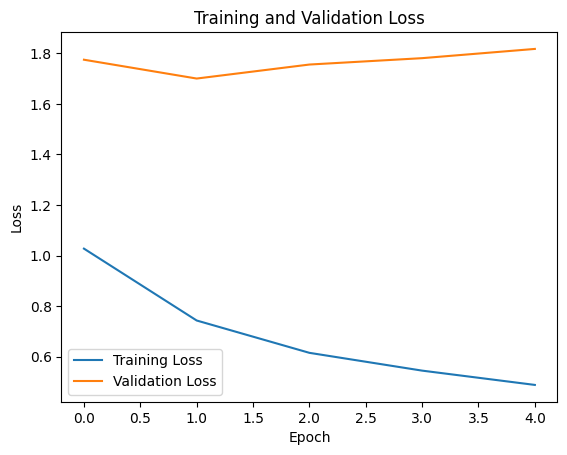

In [15]:
import matplotlib.pyplot as plt

# Plot training and validation loss
def plot_training_history(history, title="Training and Validation Loss"):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(title)
    plt.show()

# Visualize the fine-tuned model's training history
plot_training_history(history_fine_tuned)
